$$
{\Huge \text{ML with Kernels - MVA class of 2020} }\\
{\Large \text{Data challenge}}\\
\textbf{Abdelhakim Benechehab, Ichraq Lemghari}\\ %You should put your name here
\text{Due: 24 March 2020} %You should write the date here.
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import and discover the data

## Sequential data

In [4]:
xtrek0 = pd.read_csv("Xtr0.csv", index_col=0)
print(xtrek0.head())
print("\n")
print(xtrek0.info())

                                                  seq
Id                                                   
0   TCCTGTGCACATCTGCACCCCTGTTGTGGCCACAAAATGATCCGGC...
1   TTAAGTGTATATCTAATAATTTTTTTGCCTACATTCCTGTGTTACC...
2   GTGCTCAATTAGTTGCCTACAAATAGTAGCCTGGCACAGTGTAAGC...
3   CACCTGGAAAATACAAACAGGCGCAAGAAGAGTTAACCCACAGATC...
4   AAATCACTGCCTATCCTTGGGCCAAAAGGTTTCTACAGGAAGCTGC...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   seq     2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB
None


In [5]:
ytrek0 = pd.read_csv("Ytr0.csv", index_col=0)
print(ytrek0.head())
print("\n")
print(ytrek0.info())

    Bound
Id       
0       0
1       1
2       1
3       1
4       1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Bound   2000 non-null   int64
dtypes: int64(1)
memory usage: 31.2 KB
None


## Numerical data

In [6]:
df = pd.read_csv("Xtr0_mat100.csv", header=None, sep=" ")
df['y'] = ytrek0
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,y
0,0.010870,0.01087,0.043478,0.01087,0.021739,0.021739,0.000000,0.01087,0.01087,0.010870,...,0.032609,0.01087,0.010870,0.01087,0.000000,0.000000,0.010870,0.000000,0.01087,0
1,0.000000,0.00000,0.010870,0.01087,0.000000,0.010870,0.010870,0.00000,0.00000,0.000000,...,0.010870,0.01087,0.021739,0.00000,0.010870,0.021739,0.032609,0.000000,0.00000,1
2,0.021739,0.01087,0.021739,0.00000,0.000000,0.000000,0.010870,0.01087,0.00000,0.000000,...,0.000000,0.00000,0.010870,0.00000,0.021739,0.000000,0.021739,0.021739,0.01087,1
3,0.021739,0.01087,0.043478,0.00000,0.000000,0.000000,0.010870,0.00000,0.00000,0.010870,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.010870,0.000000,0.000000,0.01087,1
4,0.021739,0.01087,0.010870,0.01087,0.010870,0.010870,0.032609,0.00000,0.01087,0.043478,...,0.010870,0.00000,0.000000,0.01087,0.010870,0.032609,0.010870,0.021739,0.01087,1


## Logistic regression

The log-likelihood of the logistic regression model is given by (cross-entropy error):

$$
L_{\{(x_i,y_i)_i\}}(w,b) = \sum_{i=0}^n\{ y_i log(\sigma(w^T x_i + b)) + (1 - y_i) log(1 - \sigma(w^T x_i + b)) \}
$$

The Log-likelihood maximization problem has no tractable solution because of the Sigmoid non-linearity, hence an iterative method is used to learn the model's parameters.

We implemented *Iterated reweighted least squares*, and solve it using *Newton-Raphson* algorithm (which finally turned out to not work well probably because of the high-dimensionality of the data) based on the schema given at Chapter 4 of Christopher M. Bishop's book on pattern recognition.

In [130]:
#Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

def loss(X,w,b,y_hat):
    N = X.shape[0]
    return - (1/N) * np.sum(y_hat*np.log(yf(X,w,b)) + (1 - y_hat)*(1 - np.log(yf(X,w,b))))

#Computing predictions
def yf(X, w, b):
    return sigmoid(X.dot(w) + b)

#R matrix from bishop's book
def Rf(y):
    R = np.identity(y.size)
    R = R*(y*(1-y))
    return R

#The main function: Iteratively reweighted least squares
def irls(df):
    #Compute the sample size
    N = df.shape[0]
    M = df.shape[1] - 1
    print(N,M)
    
    X = np.array(df.iloc[:,0:-1])
    print(X.shape)
    t = np.array(df[['y']]).reshape(N)
    print(t.shape)
    
    #Initialization
    w = np.zeros(M)
    b = 0
    
    w1 = w
    b1 = b
    
    lr = 0.001
    
    #Convergence criterion
    eps = 1e-5
    
    #Max number of iterations
    max_iter = 2e+4
    
    count = 0
    
    w_track = []
    loss_track = []
    
    cond = True
    while cond:
        count += 1
        if count % 1000 == 0:
            print("checkpoint: ", count)
        
        y = yf(X, w1, b1)
        loss_track.append(loss(X,w1,b1,y))
        
        R = Rf(y)
        
        #Compute the gradients
        gradw = (X.T).dot(y - t)
        gradb = (y - t).sum()
        
        #The hessian computation was skiped since gradient descent is used at the end
        
        #Compute the hessians
#         hessw = ((X.T).dot(R)).dot(X)
#         hessb = (y*(1-y)).sum()
        
        #Check in case of singularity (not necessary for gradient descent)
        try:
            #Perform Newton optimization
            wn = w1 - lr*gradw
            w_track.append(np.linalg.norm(wn))
            bn = b1 - lr*gradb
        except:
            print("iter: ", count)
            return w, b, hess_track, w_track
        

        #Check convergence and/or max_iter reached
        if (np.linalg.norm(wn-w1) <= eps) or (count >= max_iter):
            cond = False
        else:
            w = w1
            b = b1
            
            w1 = wn
            b1 = bn
            
    print("iter: ", count)
            
    return w, b, w_track, loss_track

2000 100
(2000, 100)
(2000,)
checkpoint:  1000
checkpoint:  2000
checkpoint:  3000
checkpoint:  4000
checkpoint:  5000
checkpoint:  6000
checkpoint:  7000
checkpoint:  8000
checkpoint:  9000
checkpoint:  10000
checkpoint:  11000
checkpoint:  12000
checkpoint:  13000
checkpoint:  14000
checkpoint:  15000
checkpoint:  16000
checkpoint:  17000
checkpoint:  18000
checkpoint:  19000
checkpoint:  20000
iter:  20000
The numerical values of the learnt parameters for trainA: 
 w - [-3.96008175  0.30708786  5.16066046  7.02959519  0.12615867  6.90864295
 -2.21575247 -3.08396931  5.81585412 -3.34181492  2.25505762 -3.44401905
 -0.60007572  7.41737361 -1.76194306  1.40082749 -5.78973637 -4.82450971
  4.01823568 14.02777941 -2.13686915 -2.33617852  0.25901122 -2.96320045
 -2.38380147 -1.3466408   2.79924389 -0.42802768  4.4763639  -5.08091207
 -2.07362786  4.07351649 13.3935472  -1.01435382  2.63368031  3.83478139
  5.84987318  2.04123225 -4.37477446 -1.29694029 -4.77553264 -4.53462974
  2.98554913

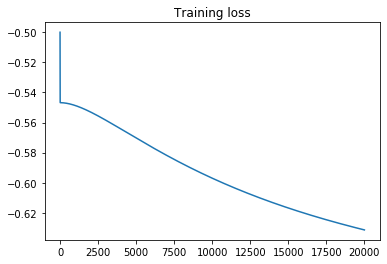

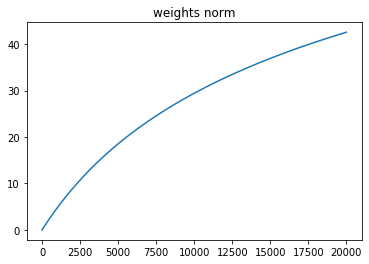

In [131]:
wA, bA, w_track, loss_track = irls(df)
print("The numerical values of the learnt parameters for trainA: \n w -", wA, "-, b -", bA)

plt.figure()
plt.plot(loss_track)
plt.title("Training loss")

plt.figure()
plt.plot(w_track)
plt.title("weights norm")

plt.show()

## Prediction on test data

In [132]:
df_test = pd.read_csv("Xte0_mat100.csv", header=None, sep=" ")
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.021739,0.00000,0.010870,0.021739,0.010870,0.01087,0.021739,0.010870,0.000000,...,0.000000,0.043478,0.00000,0.00000,0.010870,0.00000,0.000000,0.000000,0.032609,0.00000
1,0.000000,0.021739,0.00000,0.021739,0.021739,0.010870,0.01087,0.000000,0.010870,0.010870,...,0.021739,0.021739,0.00000,0.01087,0.010870,0.00000,0.010870,0.010870,0.032609,0.00000
2,0.000000,0.000000,0.01087,0.000000,0.000000,0.021739,0.00000,0.000000,0.010870,0.010870,...,0.010870,0.010870,0.01087,0.01087,0.010870,0.00000,0.021739,0.032609,0.000000,0.00000
3,0.021739,0.000000,0.00000,0.010870,0.010870,0.010870,0.00000,0.000000,0.021739,0.032609,...,0.010870,0.010870,0.00000,0.01087,0.043478,0.00000,0.021739,0.000000,0.000000,0.01087
4,0.010870,0.000000,0.01087,0.021739,0.010870,0.000000,0.00000,0.010870,0.000000,0.032609,...,0.000000,0.000000,0.00000,0.01087,0.010870,0.01087,0.010870,0.000000,0.010870,0.00000


In [133]:
X_test = np.array(df_test)
print(X_test.shape)

(1000, 100)


In [ ]:
y_test = yf(X_test, wA, bA)
print(y_test.shape)
y_test

## Compare to logistic regression from scikit learn

In [21]:
from sklearn.linear_model import LogisticRegression

N = df.shape[0]

X = np.array(df.iloc[:,0:-1])
y = np.array(df[['y']]).reshape(N)

    
clf = LogisticRegression(random_state=0).fit(X, y)

y_hat = clf.predict(X_test)

In [ ]:
rep = (y_test > 0.5).astype("int32")
rep

In [77]:
coef = clf.coef_
intercept = clf.intercept_
print(coef.shape)
print(intercept)

(1, 100)
[-0.08309935]


In [85]:
rep ^ y_hat

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

As we can see there quite differences !! However a submission with our logistic regression classifier gives reasonable performance.

## Running the algorithm for the other datasets

In [136]:
df_rep = pd.DataFrame(data=np.array([range(rep.shape[0]),rep]).T, columns=["id", "Bound"])
#df_rep.to_csv('test3.csv', index=False)

2000 100
(2000, 100)
(2000,)
checkpoint:  1000
checkpoint:  2000
checkpoint:  3000
checkpoint:  4000
checkpoint:  5000
checkpoint:  6000
checkpoint:  7000
checkpoint:  8000
checkpoint:  9000
checkpoint:  10000
checkpoint:  11000
checkpoint:  12000
checkpoint:  13000
checkpoint:  14000
checkpoint:  15000
checkpoint:  16000
checkpoint:  17000
checkpoint:  18000
checkpoint:  19000
checkpoint:  20000
iter:  20000
The numerical values of the learnt parameters for trainA: 
 w - [-2.57500641  1.88349599 -2.40137596  4.57503622 -3.26017688 -4.66232746
 -4.9908448   4.5654317   1.5328599  -1.22312985  0.69105301 -2.32573155
 -5.89386934  3.47220741  4.72350895  3.03891049  3.86796659  4.67829691
  3.05727232 -1.9952831   3.32055102 -3.53977148  1.54650402 -2.24143385
 -0.73400012  2.84939984  0.39476666 -1.36430622 -2.67066935 -3.86707574
 -3.3682295  -2.26180486  7.12912204 -8.40336949  4.54112979  2.73290258
  2.69795648 -0.12838704  4.88094918 -1.50242417 -2.88727916  2.93924875
  1.53710174

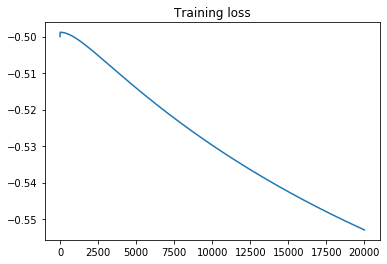

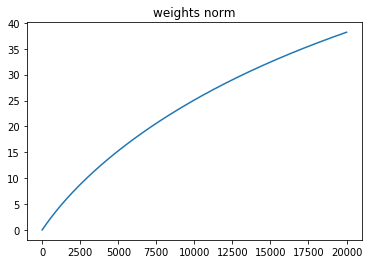

In [137]:
df = pd.read_csv("Xtr1_mat100.csv", header=None, sep=" ")
ytrek1 = pd.read_csv("Ytr1.csv", index_col=0)
df.set_index(ytrek1.index, inplace=True)
df['y'] = ytrek1['Bound']

wA, bA, w_track, loss_track = irls(df)
print("The numerical values of the learnt parameters for trainA: \n w -", wA, "-, b -", bA)

plt.figure()
plt.plot(loss_track)
plt.title("Training loss")

plt.figure()
plt.plot(w_track)
plt.title("weights norm")

plt.show()

In [138]:
df_test = pd.read_csv("Xte1_mat100.csv", header=None, sep=" ")
X_test = np.array(df_test)
y_test = yf(X_test, wA, bA)
rep = (y_test > 0.5).astype("int32")
print(rep.shape)
df_rep2 = pd.DataFrame(data=np.array([range(1000,2000),rep]).T, columns=["id", "Bound"])
df_rep2

(1000,)


,id,Bound
0,1000,0
1,1001,1
2,1002,1
3,1003,0
4,1004,1
...,...,...
995,1995,0
996,1996,1
997,1997,0
998,1998,0


2000 100
(2000, 100)
(2000,)
checkpoint:  1000
checkpoint:  2000
checkpoint:  3000
checkpoint:  4000
checkpoint:  5000
checkpoint:  6000
checkpoint:  7000
checkpoint:  8000
checkpoint:  9000
checkpoint:  10000
checkpoint:  11000
checkpoint:  12000
checkpoint:  13000
checkpoint:  14000
checkpoint:  15000
checkpoint:  16000
checkpoint:  17000
checkpoint:  18000
checkpoint:  19000
checkpoint:  20000
iter:  20000
The numerical values of the learnt parameters for trainA: 
 w - [  4.55472097   3.4813328   16.61478891  -2.40443519   2.17082482
  -0.48642229  19.42591229  -6.75719479  -0.95361075   1.11276307
  -1.3693976   -2.46174736   2.46663515   1.47945178  -4.13876264
   0.92673103   1.44542048  -3.33097396 -10.49910628   0.96616574
  -1.69275026  10.78689429   2.20445901   4.39567946  -9.01561422
  13.64699932  -4.20482554  -0.4479703    1.44756638   1.20201213
  -0.33873652  -0.74091444  -6.12869805  14.43643563  -5.11643667
  -4.67376565 -14.18011953   1.70918213  -2.45360086   3.5809

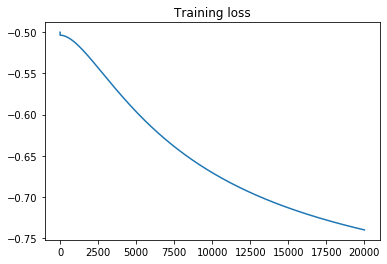

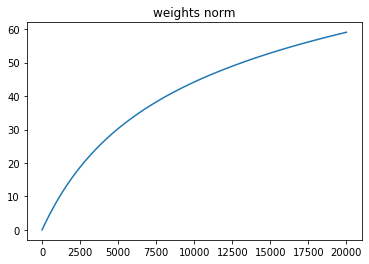

In [139]:
df = pd.read_csv("Xtr2_mat100.csv", header=None, sep=" ")
ytrek2 = pd.read_csv("Ytr2.csv", index_col=0)
df.set_index(ytrek2.index, inplace=True)
df['y'] = ytrek2['Bound']

wA, bA, w_track, loss_track = irls(df)
print("The numerical values of the learnt parameters for trainA: \n w -", wA, "-, b -", bA)

plt.figure()
plt.plot(loss_track)
plt.title("Training loss")

plt.figure()
plt.plot(w_track)
plt.title("weights norm")

plt.show()

In [140]:
df_test = pd.read_csv("Xte2_mat100.csv", header=None, sep=" ")
X_test = np.array(df_test)
y_test = yf(X_test, wA, bA)
rep = (y_test > 0.5).astype("int32")
print(rep.shape)
df_rep3 = pd.DataFrame(data=np.array([range(2000,3000),rep]).T, columns=["id", "Bound"])
df_rep3

(1000,)


,id,Bound
0,2000,0
1,2001,0
2,2002,1
3,2003,1
4,2004,1
...,...,...
995,2995,0
996,2996,0
997,2997,0
998,2998,0


## Save the data for submission

In [141]:
df_sub = pd.concat([df_rep,df_rep2,df_rep3])
df_sub

,id,Bound
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
995,2995,0
996,2996,0
997,2997,0
998,2998,0


In [142]:
df_sub.to_csv('submission2.csv', index=False)

### Thanks for reading!